<h1 style="text-align: center;">Simulación y aplicaciones en ciencias sociales y experimentales
</h3>
<h3 style="text-align: center;"> Tema 2.2 Modelos deterministas de segundo orden </h3>
<h3 style="text-align: center;"> Ejercicios propuestos </h3>

### Ejercicio 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import minimize

El siguiente modelo propone representar el proceso de regulación de la glucosa en sangre a través de la producción de insulina. Para ello seguiremos el denominado **modelo mínimo** (más detalles en [Bergman et al, 2006](https://journals.physiology.org/doi/abs/10.1152/ajpendo.1979.236.6.E667), modelo VI), que asume dos hipótesis:

1. La glucosa, una vez introducida en sangre, vuelve a sus niveles basales debido a dos efectos: reducción natural de la concentración de glucosa y el efecto de la insulina.
2. La insulina no actúa directamente, sino que primero se desplaza de la sangre al fluido que rodea al tejido celular y de ahí actúa sobre la glucosa.

El modelo mínimo consiste en dos ecuaciones diferenciales:

$$\begin{array}{l}\displaystyle{\dot{G}} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t),\\
\displaystyle{\dot{X}} = k_3 \left[I(t) - I_b \right] - k_2 X(t),\end{array}$$ 

donde $G$ y $X$ son las concentraciones de glucosa en sangre y de insulina en el fluido del tejido celular, respectivamente. La función $I(t)$ indica la concentración de insulina en sangre, que tomamos exógena. Los parámetros $G_b$ e $I_b$ son los niveles basales de glucosa e insulina en sangre, mientras que $k_1$, $k_2$ y $k_3$ son parámetros positivos que controlan las tasas de decaemiento de glucosa e insulina. Los datos que se encuentran en este [archivo](https://github.com/AllenDowney/ModSim/raw/main/data/glucose\_insulin.csv) indican la concentración en sangre de glucosa e insulina medidos durante 182 minutos a un paciente normal.

In [2]:
data = {
    "time": [0, 2, 4, 6, 8, 10, 12, 14, 16, 19, 22, 27, 32, 42, 52, 62, 72, 82, 92, 102, 122, 142, 162, 182],
    "glucose": [92, 350, 287, 251, 240, 216, 211, 205, 196, 192, 172, 163, 142, 124, 105, 92, 84, 77, 82, 81, 82, 82, 85, 90],
    "insulin": [11, 26, 130, 85, 51, 49, 45, 41, 35, 30, 30, 27, 30, 22, 15, 15, 11, 10, 8, 11, 7, 8, 8, 7]
}

df = pd.DataFrame(data)
df.head()

,time,glucose,insulin
0,0,92,11
1,2,350,26
2,4,287,130
3,6,251,85
4,8,240,51


**(a)** Estimar la concentración de glucosa en sangre a través del modelo.  En la simulación tomar como datos iniciales $k_1 = 0.02$,  $k_2 = 0.02$, $k_3 = 1.5e-05$, y unos niveles iniciales $G_0=270$ y $X_0=0$. Los niveles basales de glucosa e insulina en sangre son los iniciales de los datos reales. En la simulación es necesario interpolar los datos reales de concentración de insulina para cada minuto.

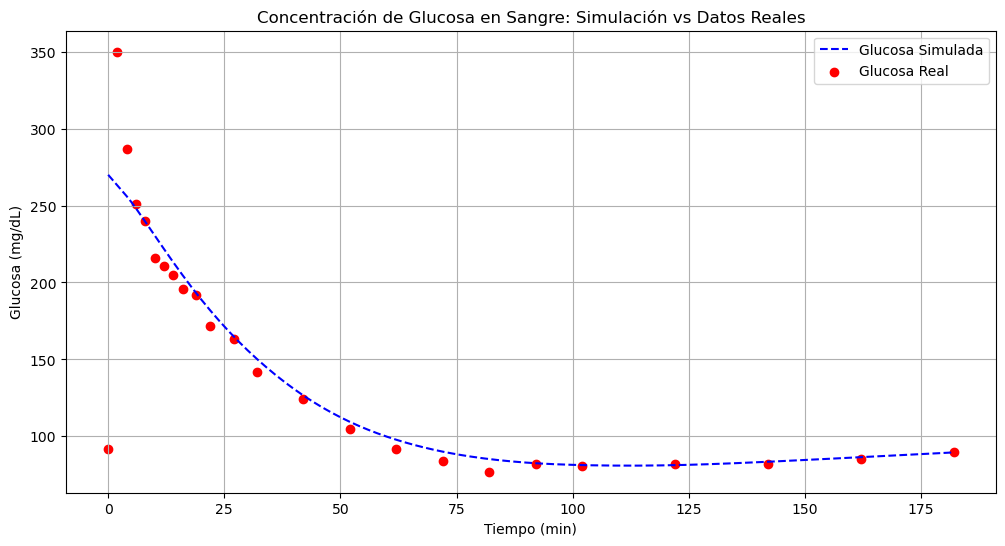

In [3]:
# Interpolar insulina para cada minuto
interp_insulin = interp1d(df['time'], df['insulin'], fill_value='extrapolate')
time_points = np.arange(0, 183, 1)  # de 0 a 182 minutos
insulin_interpolated = interp_insulin(time_points)

# Parámetros del modelo
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05
G_b = df['glucose'][0]  # Nivel basal de glucosa (inicial)
I_b = df['insulin'][0]  # Nivel basal de insulina (inicial)
G_0 = 270               # Concentración inicial de glucosa
X_0 = 0                 # Concentración inicial de insulina

# Ecuaciones diferenciales
def model(y, t, insulin, k1, k2, k3, G_b, I_b):
    G, X = y
    dGdt = -k1 * (G - G_b) - X * G
    dXdt = k3 * (insulin[int(t)] - I_b) - k2 * X  # Convertir t a entero
    return [dGdt, dXdt]

# Condiciones iniciales
y0 = [G_0, X_0]

# Resolver el sistema de ecuaciones
solution = odeint(model, y0, range(len(time_points)), args=(insulin_interpolated, k1, k2, k3, G_b, I_b))

# Extraer resultados
glucose_simulated = solution[:, 0]

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(time_points, glucose_simulated, label='Glucosa Simulada', color='blue', linestyle='--')
plt.scatter(df['time'], df['glucose'], color='red', label='Glucosa Real', marker='o')
plt.title('Concentración de Glucosa en Sangre: Simulación vs Datos Reales')
plt.xlabel('Tiempo (min)')
plt.ylabel('Glucosa (mg/dL)')
plt.legend()
plt.grid()
plt.show()

**(b)** Hallar los valores de los parámetros $k_1$, $k_2$ y $k_3$ con los que se obtenga el mejor ajuste de la simulación de la concentración de glucosa en sangre a los datos reales. Para el ajuste tomar los datos a partir de la cuarta toma de glucosa.

Valores óptimos: k1 = 0.045940355596679604, k2 = 0.028943743505771655, k3 = 2.9277360230552125e-08


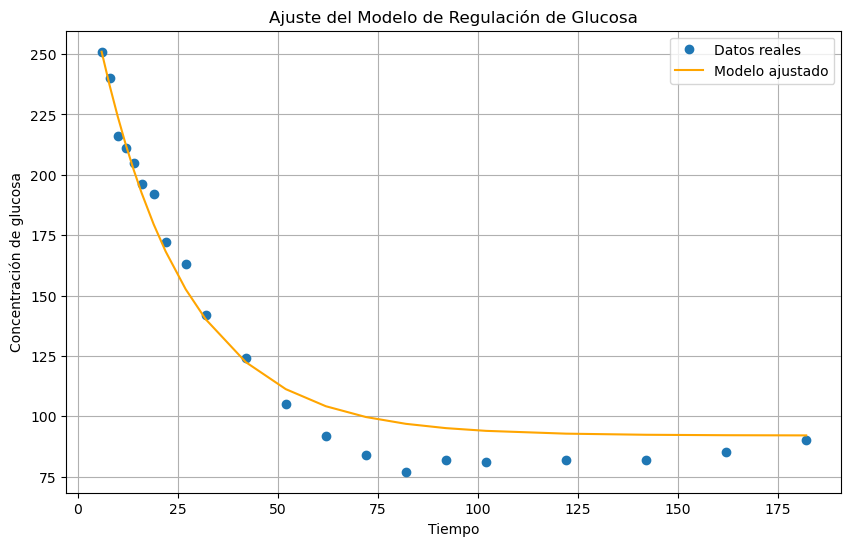

In [4]:
G_b = df['glucose'][0]
I_b = df['insulin'][0]

# Función que define el sistema de ecuaciones diferenciales
def model(y, t, k1, k2, k3):
    G, X = y
    I = np.interp(t, df['time'], df['insulin'])  # Obtener insulina usando interpolación
    dGdt = -k1 * (G - G_b) - k3 * (I - I_b) * G
    dXdt = k2 * (I - I_b) - k3 * X
    return [dGdt, dXdt]

# Función que se utiliza para la optimización
def fit_function(t, k1, k2, k3):
    y0 = [df['glucose'][3], 0]  # Condición inicial (cuarta toma de glucosa)
    sol = odeint(model, y0, t, args=(k1, k2, k3))
    return sol[:, 0]  # Retorna solo la concentración de glucosa

# Tiempos para ajuste
t_fit = df['time'][3:]

# Ajustar el modelo usando curve_fit
initial_guess = [0.01, 0.01, 0.01]
popt, pcov = curve_fit(fit_function, t_fit, df['glucose'][3:], p0=initial_guess, bounds=(0, 1))

# Parámetros óptimos
k1_opt, k2_opt, k3_opt = popt
print(f"Valores óptimos: k1 = {k1_opt}, k2 = {k2_opt}, k3 = {k3_opt}")

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df['time'][3:], df['glucose'][3:], 'o', label='Datos reales')
plt.plot(t_fit, fit_function(t_fit, *popt), '-', label='Modelo ajustado', color='orange')
plt.xlabel('Tiempo')
plt.ylabel('Concentración de glucosa')
plt.title('Ajuste del Modelo de Regulación de Glucosa')
plt.legend()
plt.grid()
plt.show()

**(c)** Realmente la producción de insulina es endógena al sistema, y se propone que sigue la siguiente ecuación: 

$$ \dot{I} = -k I + \gamma (G - G_T) t, $$

siendo $k$, $\gamma$ y $G_T$ parámetros del modelo. Obsérvese que el incremento del la insulina depende del tiempo, indicando una sensibilidad creciente de la glucosa en la producción de insulina con el tiempo. Simular el nuevo modelo con valores iniciales de $k = 0.25$, $\gamma = 0.004$ y $G_T = 80$, con unos niveles de insulina iniciales de $I_0=360$. Ajustar estos parámetros de forma que se represente lo mejor posible los datos reales a partir de la cuarta toma.     


Parámetros optimizados:
k = 0.9999999999999196
gamma = 0.020110132887606286
GT = 90.27203442123756


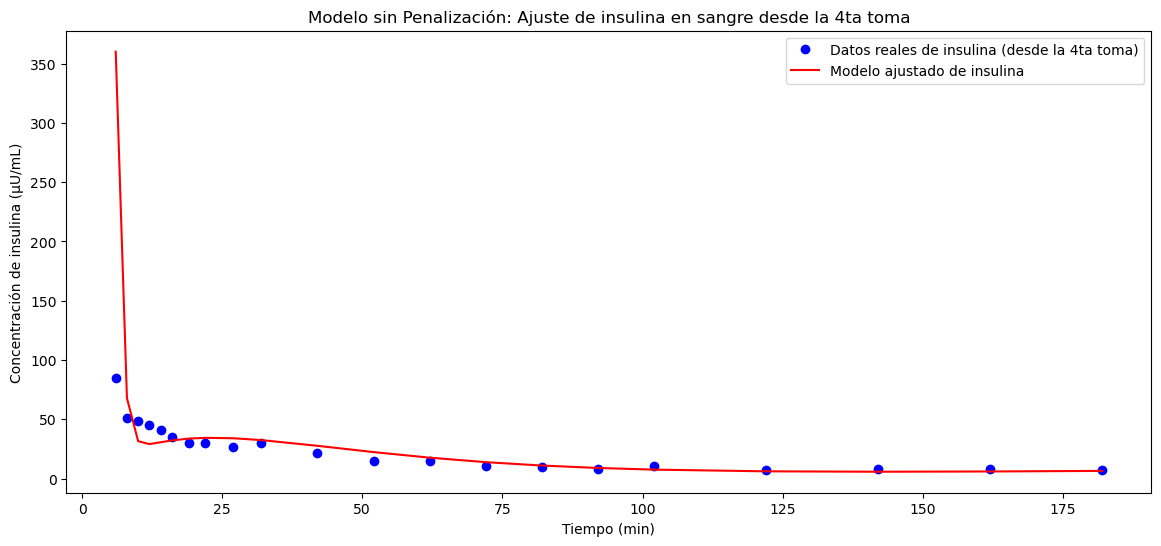

In [5]:
# Parámetros del modelo
k1 = 0.045940355596679604
k2 = 0.028943743505771655
k3 = 2.9277360230552125e-08
Gb = 92  # Nivel basal de glucosa
Ib = 11  # Nivel basal de insulina

# Filtrar datos a partir de la cuarta toma
start_index = 3  # Índice de la cuarta toma
G0 = df['glucose'][start_index]  # Glucosa inicial
X0 = 0  # Valor inicial de X
I0 = 360  # Niveles iniciales de insulina
time = np.array(df['time'])
time_filtered = time[start_index:]
insulin_filtered = df['insulin'][start_index:].values

# Función que define las ecuaciones diferenciales
def model(y, t, k, gamma, GT):
    G, X, I = y
    dG_dt = -k1 * (G - Gb) - X * G
    dX_dt = k3 * (I - Ib) - k2 * X
    dI_dt = -k * I + gamma * (G - GT) * t
    return [dG_dt, dX_dt, dI_dt]

# Función que simula la insulina
def insulin_fit(t, k, gamma, GT):
    initial_conditions = [df['glucose'][start_index], 0, 360]
    solution = odeint(model, initial_conditions, t, args=(k, gamma, GT))
    return solution[:, 2]  # Retorna solo la insulina

# Función que calcula los límites para los parámetros
def fit_with_constraints(initial_params):
    # Ajuste usando curve_fit
    popt, _ = curve_fit(insulin_fit, time_filtered, insulin_filtered, p0=initial_params, bounds=(0, [1.0, 0.1, 100]))
    return popt

# Valores iniciales
initial_params = [0.25, 0.004, 80]

# Optimización
optimized_params = fit_with_constraints(initial_params)

# Parámetros optimizados
k_opt, gamma_opt, GT_opt = optimized_params
print(f'Parámetros optimizados:')
print(f'k = {k_opt}')
print(f'gamma = {gamma_opt}')
print(f'GT = {GT_opt}')

# Graficar los resultados
I_fit = insulin_fit(time_filtered, k_opt, gamma_opt, GT_opt)

plt.figure(figsize=(14, 6))
plt.plot(time_filtered, insulin_filtered, 'bo', label='Datos reales de insulina (desde la 4ta toma)')
plt.plot(time_filtered, I_fit, 'r-', label='Modelo ajustado de insulina')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración de insulina (µU/mL)')
plt.title('Modelo sin Penalización: Ajuste de insulina en sangre desde la 4ta toma')
plt.legend()
plt.show()

# Cálculo del Error Cuadrático Medio (ECM)
ECM_model_1 = np.mean((insulin_filtered - I_fit) ** 2)

**(d)** Existen dos medidas biológicas que se construyen a partir de los parámetros del modelo:

$$ \begin{array}{l}\phi_1 = \frac{I_{max} - I_b}{k (G_0 - G_b)},\\
    \phi_2 = \gamma \times 10^4.\end{array} $$
   
Según algunos autores, los valores esperados de estos parámetros están entre 2 y 4 para $\phi_1$ y 20 y 35 para $\phi_2$. Comprobar si con el ajuste realizado los valores de estas medidas están en los rangos esperados.  

In [6]:
# Calcular φ1 y φ2 finales
I_max_final = np.max(insulin_fit(time_filtered, k_opt, gamma_opt, GT_opt))
phi_1_final = (I_max_final - Ib) / (k_opt * (G0 - Gb))
phi_2_final = gamma_opt * 10**4

print(f'Valores finales calculados:')
print(f'φ1 = {phi_1_final}')
print(f'φ2 = {phi_2_final}')
print(f'φ1 está en el rango esperado: {2 <= phi_1_final <= 4}')
print(f'φ2 está en el rango esperado: {20 <= phi_2_final <= 35}')

Valores finales calculados:
φ1 = 2.194968553459296
φ2 = 201.10132887606287
φ1 está en el rango esperado: True
φ2 está en el rango esperado: False


Como podemos observar, el modelo sin penalización mostrado en el apartado **c**, no cumple con los rangos establecidos de los parámetros $\phi_1$ y $\phi_2$. Por tanto hemos decidido implementar un modelo con penalización, el cuál se encargue de que se cumpla la condición de $\phi_1$ y $\phi_2$, mediante la implementación de una función objetivo.

Parámetros optimizados:
k = 0.559515093951392
gamma = 0.0026100117385056297
GT = 80.0


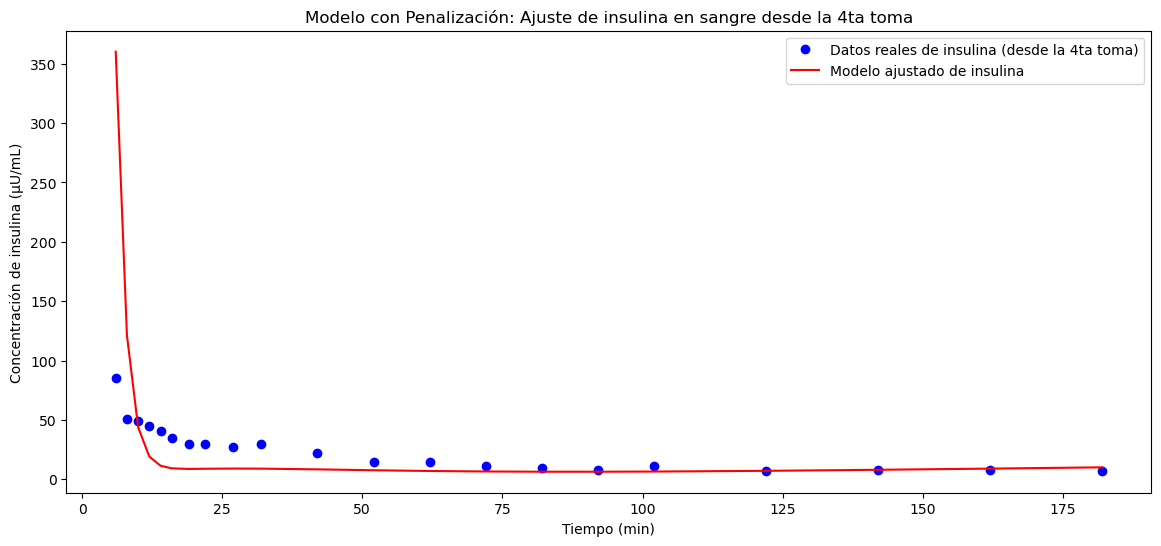

In [7]:
# Parámetros del modelo
k1 = 0.045940355596679604
k2 = 0.028943743505771655
k3 = 2.9277360230552125e-08
Gb = 92  # Nivel basal de glucosa
Ib = 11  # Nivel basal de insulina

# Filtrar datos a partir de la cuarta toma
start_index = 3  # Índice de la cuarta toma
G0 = df['glucose'][start_index]  # Glucosa inicial
X0 = 0  # Valor inicial de X
I0 = 360  # Niveles iniciales de insulina
time = np.array(df['time'])
time_filtered = time[start_index:]
insulin_filtered = df['insulin'][start_index:].values

# Función que define las ecuaciones diferenciales
def model(y, t, k, gamma, GT):
    G, X, I = y
    dG_dt = -k1 * (G - Gb) - X * G
    dX_dt = k3 * (I - Ib) - k2 * X
    dI_dt = -k * I + gamma * (G - GT) * t
    return [dG_dt, dX_dt, dI_dt]

# Función que simula la insulina
def insulin_fit(t, k, gamma, GT):
    # Resolver el sistema de ecuaciones diferenciales
    initial_conditions = [df['glucose'][start_index], 0, 360]
    solution = odeint(model, initial_conditions, t, args=(k, gamma, GT))
    I_solution = solution[:, 2]  # Solo la insulina
    return I_solution

# Función objetivo para la optimización
def objective(params):
    k, gamma, GT = params
    I_max = np.max(insulin_fit(time_filtered, k, gamma, GT))
    phi_1 = (I_max - Ib) / (k * (G0 - Gb))
    phi_2 = gamma * 10**4

    # Penalización si φ1 o φ2 están fuera de rango
    phi1_penalty = max(0, 2 - phi_1) + max(0, phi_1 - 4)
    phi2_penalty = max(0, 20 - phi_2) + max(0, phi_2 - 35)

    return phi1_penalty + phi2_penalty

# Valores iniciales y límites para los parámetros
initial_params = [0.25, 0.004, 80]
bounds = [(0.01, 1.0), (0.0001, 0.1), (50, 100)]  # Ajusta los límites según sea necesario

# Optimización
result = minimize(objective, initial_params, bounds=bounds)

# Parámetros optimizados
k_opt, gamma_opt, GT_opt = result.x
print(f'Parámetros optimizados:')
print(f'k = {k_opt}')
print(f'gamma = {gamma_opt}')
print(f'GT = {GT_opt}')

# Graficar los resultados
I_fit = insulin_fit(time_filtered, k_opt, gamma_opt, GT_opt)

plt.figure(figsize=(14, 6))
plt.plot(time_filtered, insulin_filtered, 'bo', label='Datos reales de insulina (desde la 4ta toma)')
plt.plot(time_filtered, I_fit, 'r-', label='Modelo ajustado de insulina')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración de insulina (µU/mL)')
plt.title('Modelo con Penalización: Ajuste de insulina en sangre desde la 4ta toma')
plt.legend()
plt.show()

ECM_model_2 = np.mean((insulin_filtered - I_fit) ** 2)

In [9]:
# Calcular φ1 y φ2 finales
I_max_final = np.max(insulin_fit(time_filtered, k_opt, gamma_opt, GT_opt))
phi_1_final = (I_max_final - Ib) / (k_opt * (G0 - Gb))
phi_2_final = gamma_opt * 10**4

print(f'Valores finales calculados:')
print(f'φ1 = {phi_1_final}')
print(f'φ2 = {phi_2_final}')
print(f'φ1 está en el rango esperado: {2 <= phi_1_final <= 4}')
print(f'φ2 está en el rango esperado: {20 <= phi_2_final <= 35}')

Valores finales calculados:
φ1 = 3.922983628480643
φ2 = 26.100117385056297
φ1 está en el rango esperado: True
φ2 está en el rango esperado: True


Como podemos observar, el modelo con penalización cumple con los rangos de los parámetros $\phi_1$ y $\phi_2$. Sin embargo, la simulación no se ajusta de igual manera a los datos reales que la simulación propuesta por el modelo sin penalización, es por ello que les mostraremos una tabla comparando los errores cuadráticos medios de ambos modelos para determinar si la diferencia de error es significante.

In [10]:
results = {
    'Modelo': ['Modelo Sin Penalización', 'Modelo Con Penalización'],
    'ECM': [ECM_model_1, ECM_model_2]
}

# Crear un DataFrame
df_results = pd.DataFrame(results)

# Mostrar la tabla
print(df_results)

                    Modelo          ECM
0  Modelo Sin Penalización  3657.083819
1  Modelo Con Penalización  4038.131097


Como se indica en la tabla, el modelo con penalización posee un mayor error cuadrático medio que el modelo sin penalización.

### Ejercicio 2

El oscilador de Van der Pol es un sistema dinámico creado alrededor de 1926 que consiste en un circuito eléctrico con realimentaciones positivas y resistores no lineales. El circuito, tal como se diseñó, favorece oscilaciones pequeñas y amortigua las grandes. Una extensión de estos sistemas se ha aplicado en Medicina para simular el proceso de un marcapasos. Un interesante resumen de la historia y análisis matemático del oscilador de Van der Pol lo pueden encontrar en el trabajo de [Casaico-Suárez et al. (1920)](https://www.researchgate.net/publication/344507421_El_Oscilador_de_Van_Der_Pol).

Aplicando las leyes físicas al circuito eléctrico de Van der Pol, se llega a la siguiente ecuación: 

$$\ddot{x} -\mu (1-x^2) \dot{x} +x =0,$$

donde $x$ es una combinación de las variables eléctricas del sistema (intensidad, voltaje, etc.) y $\mu$ es un parámetro de control de la resistencia. 

**a)** Simular el sistema de orden 2 para las condiciones iniciales $x(0)=0.5$, $\dot{x}(0)=0.5$ y $\mu=1$. Para ello escribir el modelo como un sistema de ecuaciones diferenciales de dos variables $x$ e $y$, con $y= \dot{x}$. Realizar la gráfica de la trayectoria de la variable $x$ y el diagrama de fases $(x,y)$. 

**b)** Hallar los puntos de equilibrio del sistema y los valores propios del sistema en función de $\mu$. Determinar valores de $\mu$ donde los valores propios cambian de signo y/o la parte imaginaria del valor propio pasa de nula a no nula o viceversa. 

**c)** Simular el modelo para valores de $\mu$ dentro de los diversos rangos definidos por los valores calculados en el apartado **b)**. Tomar distintas condiciones iniciales. 

### Ejercicio 3

En 1963, el meteorólogo E. Lorenz propuso un modelo que representa la convección de un fluido en los lados de columnas hexagonales. Las ecuaciones del modelo son las siguientes: 

$$ \begin{array}{l} \dot{x} = \sigma (y-z), \\ \dot{y} = rx -y-xz, \\ \dot{z} = xy-bz, \end{array}$$

donde $x$ mide la tasa de vuelco convectivo, $y$ la variación de temperatura horizontal y $z$ la variación de temperatura vertical.Los parámetros $\sigma$, $r$ y $b$ representan constantes relacionadas con la viscosidad del fluido y diferencias de temperatura. 

El modelo representa de forma muy simplificada el sistema del clima. Por tanto, la complejidad de las soluciones de este modelo ilustra la tremenda complejidad del clima real. Más detalles en [Lorenz (1963)](https://journals.ametsoc.org/view/journals/atsc/20/2/1520-0469_1963_020_0130_dnf_2_0_co_2.xml)

**(a)** Simular el modelo y representar las trayectorias de $x(t)$ y el diagrama de fases tridimensional $(x,y,z)$. Tomar como condición inicial $x(0) = 10$, $y(0) = z(0) = 5$, y valores de los parámetros $\sigma=10$, $b=8/3$. Tomar valores de $r$ en el conjunto $\{5, 12, 20, 28\}$. Determinar con la simulación el comportamiento asintótico de las variables. 

**(b)** Comprobar la sensibilidad de los resultados del modelo a las condiciones iniciales en los tres primeros valores de $r$ (5, 12, 20). Esto es, dado $x_\epsilon$ las solución del modelo con $x_\epsilon(0)=x(0)+\epsilon$ y $T$ un tiempo suficientemente alto, se trata de estudiar la diferencia $x(T)-x_\epsilon(T)$ en función de $\epsilon$. Debe converger a cero para $\epsilon \rightarrow 0$.

**(c)** La figura observada en el diagrama de fases en el caso $r=28$ se denomina 'Atractor de Lorenz'. Es una figura en general estable para valores de $r>25$ (comprobar). Comprobar la sensibilidad del modelo a las condiciones iniciales para $r=28$ (o cualquier otro que presente el atractor de Lorenz).  